In [20]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import homogeneity_score, completeness_score,silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,AgglomerativeClustering

# Problem 1

In [15]:
#Load Dataset
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
                'acceleration', 'model_year', 'origin', 'car_name']
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

df = pd.read_csv(url, delim_whitespace=True, names=column_names, na_values='?')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [16]:
#Select continuous features: only feature with float data types are considered
continuous_cols = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']      
df_cont = df[continuous_cols]

In [17]:
#Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
df_cont_imputed = pd.DataFrame(imputer.fit_transform(df_cont), columns=continuous_cols)

In [18]:
#Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cont_imputed)

In [21]:
#Hierarchical Clustering (Dendrogram)
agglo = AgglomerativeClustering(n_clusters=3, linkage='average', metric='euclidean')
agglo_labels = agglo.fit_predict(df_scaled)
df['hierarchical_cluster'] = agglo_labels
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,hierarchical_cluster
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino,1


In [22]:
#Cluster statistics
print("\nHierarchical Cluster Stats:")
print(df.groupby('hierarchical_cluster')[continuous_cols].agg(['mean', 'var']))

print("\nOrigin Class Stats:")
print(df.groupby('origin')[continuous_cols].agg(['mean', 'var']))


Hierarchical Cluster Stats:
                            mpg            displacement               \
                           mean        var         mean          var   
hierarchical_cluster                                                   
0                     26.177441  41.303375   144.304714  3511.485383   
1                     14.528866   4.771033   348.020619  2089.499570   
2                     43.700000   0.300000    91.750000    12.250000   

                      horsepower                   weight                 \
                            mean         var         mean            var   
hierarchical_cluster                                                       
0                      86.120275  294.554450  2598.414141  299118.709664   
1                     161.804124  674.075816  4143.969072  193847.051117   
2                      49.000000    4.000000  2133.750000   21672.916667   

                     acceleration            
                             mean  

In [23]:
#Compare cluster with origin label
print("\nHierarchical vs Origin:\n", pd.crosstab(df['origin'], df['hierarchical_cluster']))


Hierarchical vs Origin:
 hierarchical_cluster    0   1  2
origin                          
1                     152  97  0
2                      66   0  4
3                      79   0  0


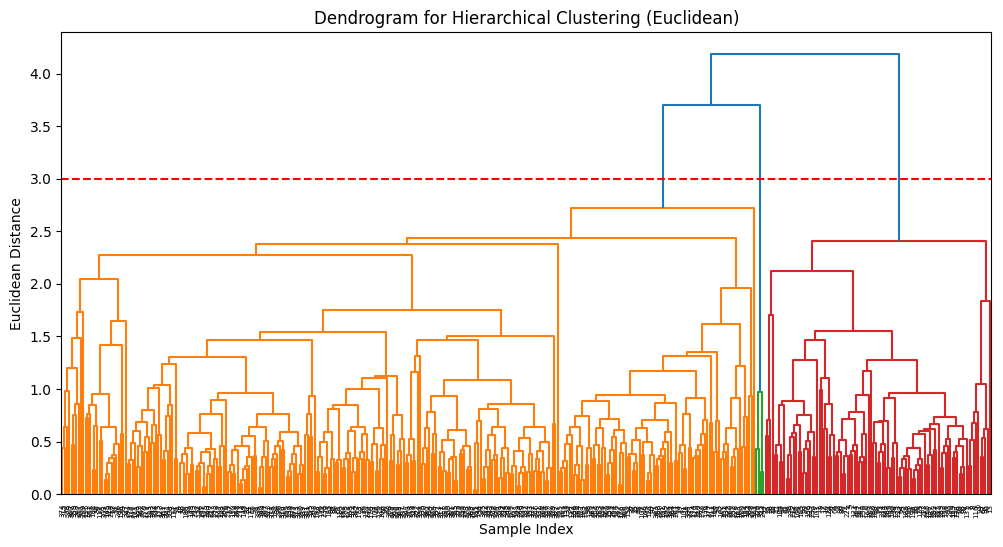

In [24]:
#Plot the hierarchical clustering dendrogram
plt.figure(figsize=(12, 6))
linked = linkage(df_scaled, method='average', metric='euclidean') 
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram for Hierarchical Clustering (Euclidean)')
plt.xlabel('Sample Index')
plt.ylabel('Euclidean Distance')
plt.axhline(y=3, color='r', linestyle='--')  # Adjust line position based on dendrogram
plt.show()

In [25]:
#Calculate Hierarchical F-measure
# Calculate the total number of objects m
m = len(df)
# Group by class labels and calculate the number of objects m_j in each class j
class_counts = df['origin'].value_counts()
total_f_measure = 0

for class_value in class_counts.index:
    # Get the number of objects m_j in class j
    m_j = class_counts[class_value]
    f_measures = []
    for cluster_value in df['hierarchical_cluster'].unique():
        # Calculate the number of objects in cluster i that belong to class j
        num_in_cluster_and_class = len(df[(df['hierarchical_cluster'] == cluster_value) & (df['origin'] == class_value)])
        num_in_cluster = len(df[df['hierarchical_cluster'] == cluster_value])
        num_in_class = len(df[df['origin'] == class_value])
        precision = num_in_cluster_and_class / num_in_cluster if num_in_cluster > 0 else 0
        recall = num_in_cluster_and_class / num_in_class if num_in_class > 0 else 0
        f_measure = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        f_measures.append(f_measure)
    max_f_measure = max(f_measures)
    total_f_measure += (m_j / m) * max_f_measure

print(f"\nHierarchical F-measure: {total_f_measure}")


Hierarchical F-measure: 0.4974538617845863


# Problem 2

In [26]:
#Load Dataset
df2 = pd.read_csv(r"D:\桌面\数据挖掘\Week 10\Boston.csv",na_values='?')
df2 = df2.iloc[:, 1:]
df2.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [27]:
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(df2)

In [28]:
#Standardize data
scaler = StandardScaler()
df2_scaled = scaler.fit_transform(df2)

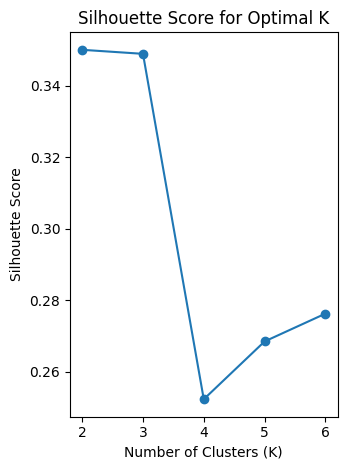

best_k: 2，silhouette coefficient: 0.35010701730151716


In [29]:
#Silhouette Score
silhouette_scores = []
best_score = -1
best_k = 0

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(df2_scaled)
    score = silhouette_score(df2_scaled, labels)
    silhouette_scores.append(score)
     #Update the optimal silhouette coefficient and the corresponding k value
    if score > best_score:
        best_score = score
        best_k = k

plt.subplot(1, 2, 2)
plt.plot(range(2, 7), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.tight_layout()
plt.show()
print(f"best_k: {best_k}，silhouette coefficient: {best_score}")

In [30]:
kmeans = KMeans(n_clusters=best_k, random_state=0)
labels = kmeans.fit_predict(df2_scaled)

#Calculate the mean value of all features in each cluster
cluster_means = pd.DataFrame(df2_scaled).groupby(labels).mean()
#Centroid coordinates
centroids = kmeans.cluster_centers_

np.set_printoptions(suppress=True, precision=16)
pd.set_option('display.float_format', lambda x: '{:.16f}'.format(x))

print("The mean value of all features in each cluster:")
print(cluster_means)
print("Centroid coordinates:")
print(centroids) 

The mean value of all features in each cluster:
                   0                   1                   2   \
0 -0.3898012191570719  0.2623916673149328 -0.6152940245726287   
1  0.7245457689416755 -0.4877223646701291  1.1436821134711581   

                   3                   4                   5   \
0  0.0029118214285368 -0.5829159437747091  0.2449126250915631   
1 -0.0054123686440034  1.0834991271292609 -0.4552330714978773   

                   6                   7                   8   \
0 -0.4335841611084604  0.4544914112686059 -0.5834517228200965   
1  0.8059276214953864 -0.8447891203806294  1.0844950102136257   

                   9                   10                  11  \
0 -0.6297268870156213 -0.2946620052887642  0.3286002735406785   
1  1.1705092984640646  0.5477050832768544 -0.6107880790671389   

                   12                  13  
0 -0.4534974696857152  0.3536413215392679  
1  0.8429416244440686 -0.6573333038780759  
Centroid coordinates:
[[-0.389801219

# Problem 3

In [31]:
#Load Dataset
wine = load_wine()
df3 = pd.DataFrame(wine.data, columns=wine.feature_names)
target = wine.target

In [32]:
#Impute missing values with mean
df3= df3.replace('?', np.nan)
imputer = SimpleImputer(strategy='mean')
data= imputer.fit_transform(df3)

In [33]:
#Standardize data
scaler = StandardScaler()
df3_scaled = scaler.fit_transform(data)

In [34]:
# K-Means with optimal K
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(df3_scaled)

In [35]:
# Calculate homogeneity and completeness
homogeneity = homogeneity_score(target, labels)
completeness = completeness_score(target, labels)

print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")

Homogeneity: 0.8788432003662366
Completeness: 0.8729636016078731
